# XGBoost

In [7]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

cn_df = pd.read_csv('train_data/cn_price_score.csv')
us_df = pd.read_csv('train_data/us_price_score.csv')

for df in [cn_df, us_df]:
    df['date'] = pd.to_datetime(df['date'])
    df.sort_values('date', inplace=True)
    df['sentiment_lag1'] = df['sentiment_score'].shift(1)

lags = [1, 2, 3, 4, 5, 10, 15, 20]

def create_features(df, use_sentiment=True):
    df = df.copy()
    for lag in lags:
        df[f'price_lag_{lag}'] = df['Price'].shift(lag)
    if use_sentiment:
        features = [f'price_lag_{lag}' for lag in lags] + ['sentiment_lag1']
    else:
        features = [f'price_lag_{lag}' for lag in lags]
    
    df['target_price'] = df['Price'].shift(-1)
    df = df.dropna(subset=features + ['target_price'])

    X = df[features]
    y = df['target_price']
    return X, y

def train_eval_split(X, y, ratio=0.8):
    split_idx = int(len(X) * ratio)
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

    model = XGBRegressor(n_estimators=50, max_depth=3, random_state=42)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    return {
        "model": model,
        "MAE": mean_absolute_error(y_test, preds),
        "RMSE": np.sqrt(np.mean((y_test - preds) ** 2)),
        "R2": r2_score(y_test, preds)
    }

X_cn_nosent, y_cn_nosent = create_features(cn_df, use_sentiment=False)
X_cn_sent, y_cn_sent = create_features(cn_df, use_sentiment=True)

X_us_nosent, y_us_nosent = create_features(us_df, use_sentiment=False)
X_us_sent, y_us_sent = create_features(us_df, use_sentiment=True)

results = [
    {"Country": "China", "Model": "No Sentiment", **train_eval_split(X_cn_nosent, y_cn_nosent)},
    {"Country": "China", "Model": "With Sentiment", **train_eval_split(X_cn_sent, y_cn_sent)},
    {"Country": "US", "Model": "No Sentiment", **train_eval_split(X_us_nosent, y_us_nosent)},
    {"Country": "US", "Model": "With Sentiment", **train_eval_split(X_us_sent, y_us_sent)},
]

results_df = pd.DataFrame(results)[["Country", "Model", "MAE", "RMSE", "R2"]]
print(results_df)

  Country           Model         MAE        RMSE        R2
0   China    No Sentiment   53.878147   64.982138  0.116434
1   China  With Sentiment   47.287635   58.780469  0.277035
2      US    No Sentiment  116.439393  154.656809 -1.264104
3      US  With Sentiment  106.162606  141.269175 -0.889092


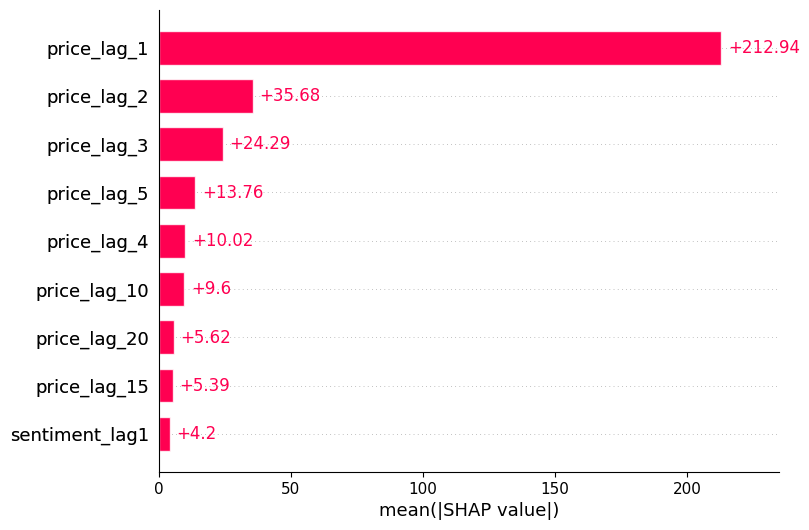

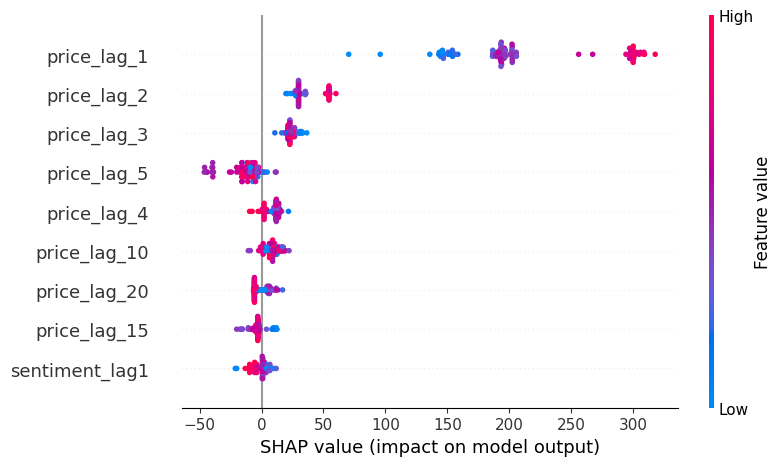

In [8]:
import shap
import matplotlib.pyplot as plt

X_cn_sent, y_cn_sent = create_features(cn_df, use_sentiment=True)

split_idx = int(len(X_cn_sent) * 0.8)
X_train = X_cn_sent.iloc[:split_idx]
y_train = y_cn_sent.iloc[:split_idx]
X_test = X_cn_sent.iloc[split_idx:]
y_test = y_cn_sent.iloc[split_idx:]

xgb_model = XGBRegressor(n_estimators=50, max_depth=3, random_state=42)
xgb_model.fit(X_train, y_train)

explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_test)

shap.plots.bar(shap_values, max_display=10)

shap.plots.beeswarm(shap_values, max_display=10)


Loading and preparing data...

China Market Data:
  Date range: 2018-01-02 00:00:00 to 2019-12-31 00:00:00
  Price range: $2964.84 to $4389.89
  Sentiment range: -0.567 to 0.797
  Total samples: 474

US Market Data:
  Date range: 2018-01-02 00:00:00 to 2019-12-31 00:00:00
  Price range: $2351.10 to $3240.00
  Sentiment range: -0.267 to 0.641
  Total samples: 500

Creating features and training models...

COMPREHENSIVE MARKET SENTIMENT ANALYSIS RESULTS

Model Performance Comparison:
--------------------------------------------------------------------------------
Country                      Model  Features test_r2 test_mae test_rmse test_mape direction_accuracy
  China                 Price Only         7  0.2736    46.27     58.92      1.2%              47.8%
  China    Price + Basic Sentiment         8  0.1448    51.49     63.93      1.3%              46.7%
  China Price + Extended Sentiment        12  0.2359    48.83     60.43      1.2%              50.0%
     US                 Pric

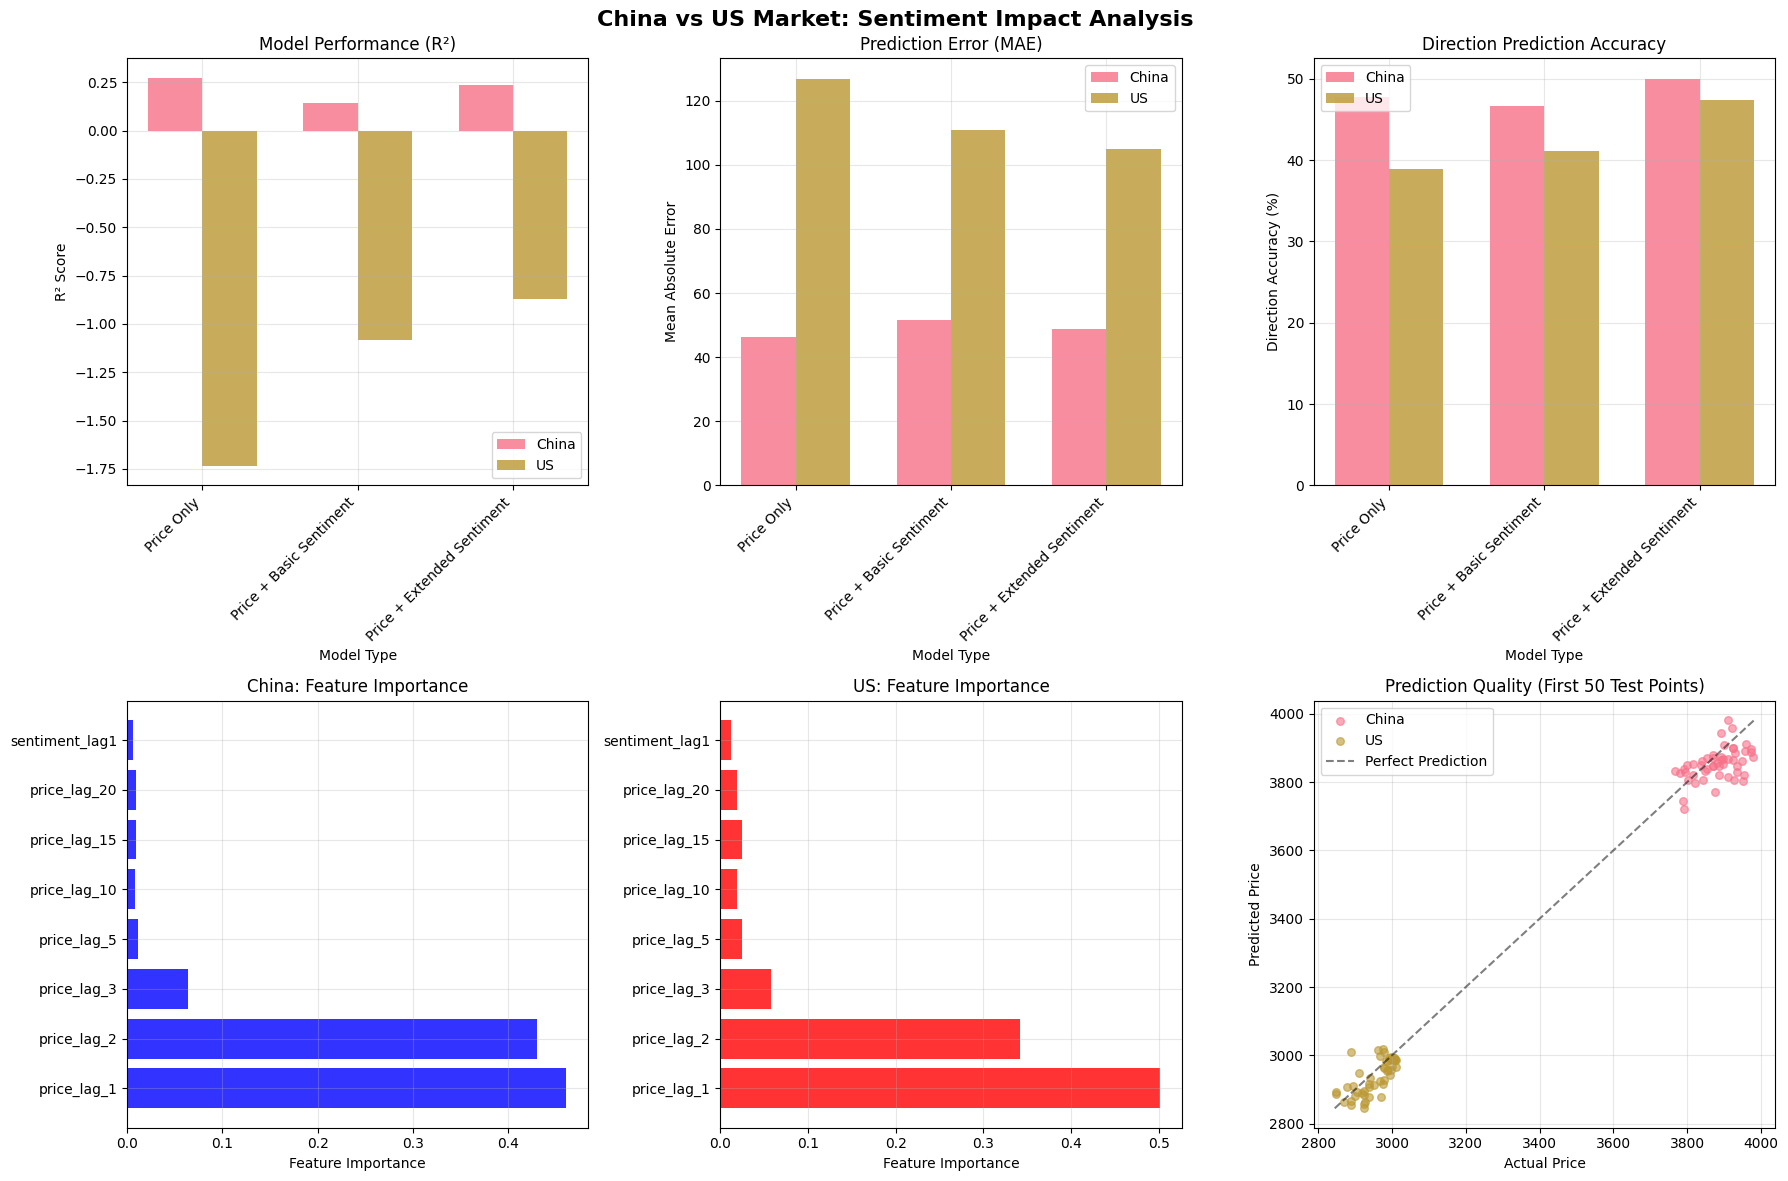


KEY INSIGHTS
1. Sentiment adds more predictive power to US market
   China R² gain: -0.1289
   US R² gain: +0.6497

2. Overall model performance:
   China best R²: 0.2736
   US best R²: -0.8728
   China market is more predictable

3. Sentiment feature importance:
   China sentiment importance: 0.006
   US sentiment importance: 0.013


In [24]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")

print("Loading and preparing data...")
cn_df = pd.read_csv('train_data/cn_price_score.csv')
us_df = pd.read_csv('train_data/us_price_score.csv')

# Data preprocessing
for df, name in [(cn_df, 'China'), (us_df, 'US')]:
    df['date'] = pd.to_datetime(df['date'])
    df.sort_values('date', inplace=True)
    df['sentiment_lag1'] = df['sentiment_score'].shift(1)
    df['sentiment_lag2'] = df['sentiment_score'].shift(2)
    df['sentiment_lag3'] = df['sentiment_score'].shift(3)
    df['price_return'] = df['Price'].pct_change()
    df['price_volatility'] = df['price_return'].rolling(window=5).std()
    df['sentiment_ma3'] = df['sentiment_score'].rolling(window=3).mean()
    df['sentiment_ma5'] = df['sentiment_score'].rolling(window=5).mean()
    
    print(f"\n{name} Market Data:")
    print(f"  Date range: {df['date'].min()} to {df['date'].max()}")
    print(f"  Price range: ${df['Price'].min():.2f} to ${df['Price'].max():.2f}")
    print(f"  Sentiment range: {df['sentiment_score'].min():.3f} to {df['sentiment_score'].max():.3f}")
    print(f"  Total samples: {len(df)}")

# Enhanced feature creation
lags = [1, 2, 3, 5, 10, 15, 20]

def create_enhanced_features(df, use_sentiment=True, sentiment_features='basic'):
    df = df.copy()
    
    # Price lag features
    for lag in lags:
        df[f'price_lag_{lag}'] = df['Price'].shift(lag)
        df[f'return_lag_{lag}'] = df['price_return'].shift(lag)
    
    # Base features
    base_features = [f'price_lag_{lag}' for lag in lags]
    
    if use_sentiment:
        if sentiment_features == 'basic':
            sentiment_cols = ['sentiment_lag1']
        elif sentiment_features == 'extended':
            sentiment_cols = ['sentiment_lag1', 'sentiment_lag2', 'sentiment_lag3', 
                            'sentiment_ma3', 'sentiment_ma5']
        features = base_features + sentiment_cols
    else:
        features = base_features
    
    # Target (next day price)
    df['target_price'] = df['Price'].shift(-1)
    
    # Clean data
    df = df.dropna(subset=features + ['target_price'])
    
    X = df[features]
    y = df['target_price']
    
    return X, y, df

def train_and_evaluate(X, y, model_name="XGBoost", test_ratio=0.2):
    """Enhanced training and evaluation with more metrics"""
    # Time-based split (no shuffling)
    split_idx = int(len(X) * (1 - test_ratio))
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
    
    # Train model
    model = XGBRegressor(
        n_estimators=100,
        max_depth=4,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        verbosity=0
    )
    
    model.fit(X_train, y_train)
    
    # Predictions
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)
    
    # Calculate metrics
    train_mae = mean_absolute_error(y_train, train_preds)
    test_mae = mean_absolute_error(y_test, test_preds)
    train_rmse = np.sqrt(mean_squared_error(y_train, train_preds))
    test_rmse = np.sqrt(mean_squared_error(y_test, test_preds))
    train_r2 = r2_score(y_train, train_preds)
    test_r2 = r2_score(y_test, test_preds)
    
    # MAPE calculation
    test_mape = np.mean(np.abs((y_test - test_preds) / y_test)) * 100
    
    # Direction accuracy (did we predict the right direction?)
    actual_direction = (y_test.values[1:] > y_test.values[:-1]).astype(int)
    pred_direction = (test_preds[1:] > test_preds[:-1]).astype(int)
    direction_accuracy = np.mean(actual_direction == pred_direction) * 100
    
    return {
        "model": model,
        "train_mae": train_mae,
        "test_mae": test_mae,
        "train_rmse": train_rmse,
        "test_rmse": test_rmse,
        "train_r2": train_r2,
        "test_r2": test_r2,
        "test_mape": test_mape,
        "direction_accuracy": direction_accuracy,
        "feature_importance": dict(zip(X.columns, model.feature_importances_)),
        "predictions": test_preds,
        "actuals": y_test.values
    }

print("\nCreating features and training models...")

# Create different feature sets
experiments = []

for df, country in [(cn_df, 'China'), (us_df, 'US')]:
    # Basic features without sentiment
    X_basic, y_basic, df_clean = create_enhanced_features(df, use_sentiment=False)
    basic_results = train_and_evaluate(X_basic, y_basic, f"{country}_Basic")
    
    # Basic features with sentiment
    X_sent_basic, y_sent_basic, _ = create_enhanced_features(df, use_sentiment=True, sentiment_features='basic')
    sent_basic_results = train_and_evaluate(X_sent_basic, y_sent_basic, f"{country}_Sentiment_Basic")
    
    # Extended sentiment features
    X_sent_ext, y_sent_ext, _ = create_enhanced_features(df, use_sentiment=True, sentiment_features='extended')
    sent_ext_results = train_and_evaluate(X_sent_ext, y_sent_ext, f"{country}_Sentiment_Extended")
    
    experiments.extend([
        {
            "Country": country,
            "Model": "Price Only",
            "Features": len(X_basic.columns),
            **{k: v for k, v in basic_results.items() if k not in ['model', 'feature_importance', 'predictions', 'actuals']}
        },
        {
            "Country": country,
            "Model": "Price + Basic Sentiment",
            "Features": len(X_sent_basic.columns),
            **{k: v for k, v in sent_basic_results.items() if k not in ['model', 'feature_importance', 'predictions', 'actuals']}
        },
        {
            "Country": country,
            "Model": "Price + Extended Sentiment",
            "Features": len(X_sent_ext.columns),
            **{k: v for k, v in sent_ext_results.items() if k not in ['model', 'feature_importance', 'predictions', 'actuals']}
        }
    ])
    
    # Store detailed results for analysis
    if country == 'China':
        cn_results = {
            'basic': basic_results,
            'sent_basic': sent_basic_results,
            'sent_extended': sent_ext_results
        }
    else:
        us_results = {
            'basic': basic_results,
            'sent_basic': sent_basic_results,
            'sent_extended': sent_ext_results
        }

# Create results DataFrame
results_df = pd.DataFrame(experiments)

print("\n" + "="*80)
print("COMPREHENSIVE MARKET SENTIMENT ANALYSIS RESULTS")
print("="*80)

# Display main results
print("\nModel Performance Comparison:")
print("-" * 80)
display_cols = ['Country', 'Model', 'Features', 'test_r2', 'test_mae', 'test_rmse', 'test_mape', 'direction_accuracy']
formatted_df = results_df[display_cols].copy()
formatted_df['test_r2'] = formatted_df['test_r2'].apply(lambda x: f"{x:.4f}")
formatted_df['test_mae'] = formatted_df['test_mae'].apply(lambda x: f"{x:.2f}")
formatted_df['test_rmse'] = formatted_df['test_rmse'].apply(lambda x: f"{x:.2f}")
formatted_df['test_mape'] = formatted_df['test_mape'].apply(lambda x: f"{x:.1f}%")
formatted_df['direction_accuracy'] = formatted_df['direction_accuracy'].apply(lambda x: f"{x:.1f}%")

print(formatted_df.to_string(index=False))

# Calculate sentiment impact
print("\n" + "="*50)
print("SENTIMENT IMPACT ANALYSIS")
print("="*50)

for country in ['China', 'US']:
    country_data = results_df[results_df['Country'] == country]
    baseline = country_data[country_data['Model'] == 'Price Only'].iloc[0]
    basic_sent = country_data[country_data['Model'] == 'Price + Basic Sentiment'].iloc[0]
    ext_sent = country_data[country_data['Model'] == 'Price + Extended Sentiment'].iloc[0]
    
    print(f"\n{country} Market:")
    print(f"  Baseline R²: {baseline['test_r2']:.4f}")
    print(f"  Basic Sentiment R²: {basic_sent['test_r2']:.4f} (Δ: {basic_sent['test_r2'] - baseline['test_r2']:+.4f})")
    print(f"  Extended Sentiment R²: {ext_sent['test_r2']:.4f} (Δ: {ext_sent['test_r2'] - baseline['test_r2']:+.4f})")
    
    basic_improvement = ((baseline['test_mae'] - basic_sent['test_mae']) / baseline['test_mae']) * 100
    ext_improvement = ((baseline['test_mae'] - ext_sent['test_mae']) / baseline['test_mae']) * 100
    
    print(f"  MAE Improvement - Basic: {basic_improvement:+.1f}%")
    print(f"  MAE Improvement - Extended: {ext_improvement:+.1f}%")
    print(f"  Direction Accuracy - Baseline: {baseline['direction_accuracy']:.1f}%")
    print(f"  Direction Accuracy - With Sentiment: {basic_sent['direction_accuracy']:.1f}%")

# Statistical significance test
print("\n" + "="*50)
print("STATISTICAL SIGNIFICANCE TESTS")
print("="*50)

def test_significance(results1, results2, name1, name2):
    """Test if difference in predictions is statistically significant"""
    preds1, actuals1 = results1['predictions'], results1['actuals']
    preds2, actuals2 = results2['predictions'], results2['actuals']
    
    # Ensure same length
    min_len = min(len(preds1), len(preds2))
    preds1, preds2 = preds1[:min_len], preds2[:min_len]
    actuals1, actuals2 = actuals1[:min_len], actuals2[:min_len]
    
    # Calculate residuals
    residuals1 = np.abs(actuals1 - preds1)
    residuals2 = np.abs(actuals2 - preds2)
    
    # Wilcoxon signed-rank test
    statistic, p_value = stats.wilcoxon(residuals1, residuals2, alternative='two-sided')
    
    print(f"{name1} vs {name2}:")
    print(f"  p-value: {p_value:.4f}")
    print(f"  Significant at α=0.05: {'Yes' if p_value < 0.05 else 'No'}")
    return p_value < 0.05

print("\nChina Market:")
test_significance(cn_results['basic'], cn_results['sent_basic'], 
                 "Price Only", "Price + Sentiment")

print("\nUS Market:")
test_significance(us_results['basic'], us_results['sent_basic'], 
                 "Price Only", "Price + Sentiment")

# Feature importance analysis
print("\n" + "="*50)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*50)

for country, results in [('China', cn_results), ('US', us_results)]:
    print(f"\n{country} Market - Top Features (with sentiment):")
    importance = results['sent_basic']['feature_importance']
    sorted_features = sorted(importance.items(), key=lambda x: x[1], reverse=True)
    
    for feature, imp in sorted_features[:8]:
        print(f"  {feature}: {imp:.3f}")
    
    # Sentiment importance
    sentiment_importance = importance.get('sentiment_lag1', 0)
    total_importance = sum(importance.values())
    sentiment_pct = (sentiment_importance / total_importance) * 100
    print(f"  Sentiment contribution: {sentiment_pct:.1f}% of total importance")

# Visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('China vs US Market: Sentiment Impact Analysis', fontsize=16, fontweight='bold')

# 1. R² Comparison
ax1 = axes[0, 0]
countries = ['China', 'US']
models = ['Price Only', 'Price + Basic Sentiment', 'Price + Extended Sentiment']
r2_data = []

for country in countries:
    country_r2 = []
    for model in models:
        r2 = results_df[(results_df['Country'] == country) & (results_df['Model'] == model)]['test_r2'].iloc[0]
        country_r2.append(r2)
    r2_data.append(country_r2)

x = np.arange(len(models))
width = 0.35
ax1.bar(x - width/2, r2_data[0], width, label='China', alpha=0.8)
ax1.bar(x + width/2, r2_data[1], width, label='US', alpha=0.8)
ax1.set_xlabel('Model Type')
ax1.set_ylabel('R² Score')
ax1.set_title('Model Performance (R²)')
ax1.set_xticks(x)
ax1.set_xticklabels(models, rotation=45, ha='right')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. MAE Comparison
ax2 = axes[0, 1]
mae_data = []
for country in countries:
    country_mae = []
    for model in models:
        mae = results_df[(results_df['Country'] == country) & (results_df['Model'] == model)]['test_mae'].iloc[0]
        country_mae.append(mae)
    mae_data.append(country_mae)

ax2.bar(x - width/2, mae_data[0], width, label='China', alpha=0.8)
ax2.bar(x + width/2, mae_data[1], width, label='US', alpha=0.8)
ax2.set_xlabel('Model Type')
ax2.set_ylabel('Mean Absolute Error')
ax2.set_title('Prediction Error (MAE)')
ax2.set_xticks(x)
ax2.set_xticklabels(models, rotation=45, ha='right')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Direction Accuracy
ax3 = axes[0, 2]
dir_data = []
for country in countries:
    country_dir = []
    for model in models:
        dir_acc = results_df[(results_df['Country'] == country) & (results_df['Model'] == model)]['direction_accuracy'].iloc[0]
        country_dir.append(dir_acc)
    dir_data.append(country_dir)

ax3.bar(x - width/2, dir_data[0], width, label='China', alpha=0.8)
ax3.bar(x + width/2, dir_data[1], width, label='US', alpha=0.8)
ax3.set_xlabel('Model Type')
ax3.set_ylabel('Direction Accuracy (%)')
ax3.set_title('Direction Prediction Accuracy')
ax3.set_xticks(x)
ax3.set_xticklabels(models, rotation=45, ha='right')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Feature Importance (China)
ax4 = axes[1, 0]
cn_importance = cn_results['sent_basic']['feature_importance']
features = list(cn_importance.keys())[:8]
importances = [cn_importance[f] for f in features]
ax4.barh(features, importances, alpha=0.8, color='blue')
ax4.set_xlabel('Feature Importance')
ax4.set_title('China: Feature Importance')
ax4.grid(True, alpha=0.3)

# 5. Feature Importance (US)
ax5 = axes[1, 1]
us_importance = us_results['sent_basic']['feature_importance']
features = list(us_importance.keys())[:8]
importances = [us_importance[f] for f in features]
ax5.barh(features, importances, alpha=0.8, color='red')
ax5.set_xlabel('Feature Importance')
ax5.set_title('US: Feature Importance')
ax5.grid(True, alpha=0.3)

# 6. Prediction Quality Scatter
ax6 = axes[1, 2]
# China predictions
cn_preds = cn_results['sent_basic']['predictions'][:50]
cn_actuals = cn_results['sent_basic']['actuals'][:50]
ax6.scatter(cn_actuals, cn_preds, alpha=0.6, label='China', s=30)

# US predictions  
us_preds = us_results['sent_basic']['predictions'][:50]
us_actuals = us_results['sent_basic']['actuals'][:50]
ax6.scatter(us_actuals, us_preds, alpha=0.6, label='US', s=30)

# Perfect prediction line
all_values = np.concatenate([cn_actuals, us_actuals, cn_preds, us_preds])
min_val, max_val = np.min(all_values), np.max(all_values)
ax6.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5, label='Perfect Prediction')

ax6.set_xlabel('Actual Price')
ax6.set_ylabel('Predicted Price')
ax6.set_title('Prediction Quality (First 50 Test Points)')
ax6.legend()
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary insights
print("\n" + "="*60)
print("KEY INSIGHTS")
print("="*60)

cn_sentiment_r2_gain = results_df[(results_df['Country'] == 'China') & (results_df['Model'] == 'Price + Basic Sentiment')]['test_r2'].iloc[0] - \
                       results_df[(results_df['Country'] == 'China') & (results_df['Model'] == 'Price Only')]['test_r2'].iloc[0]

us_sentiment_r2_gain = results_df[(results_df['Country'] == 'US') & (results_df['Model'] == 'Price + Basic Sentiment')]['test_r2'].iloc[0] - \
                       results_df[(results_df['Country'] == 'US') & (results_df['Model'] == 'Price Only')]['test_r2'].iloc[0]

print(f"1. Sentiment adds more predictive power to {'China' if cn_sentiment_r2_gain > us_sentiment_r2_gain else 'US'} market")
print(f"   China R² gain: {cn_sentiment_r2_gain:+.4f}")
print(f"   US R² gain: {us_sentiment_r2_gain:+.4f}")

print(f"\n2. Overall model performance:")
cn_best_r2 = results_df[results_df['Country'] == 'China']['test_r2'].max()
us_best_r2 = results_df[results_df['Country'] == 'US']['test_r2'].max()
print(f"   China best R²: {cn_best_r2:.4f}")
print(f"   US best R²: {us_best_r2:.4f}")
print(f"   {'China' if cn_best_r2 > us_best_r2 else 'US'} market is more predictable")

print(f"\n3. Sentiment feature importance:")
cn_sent_importance = cn_results['sent_basic']['feature_importance'].get('sentiment_lag1', 0)
us_sent_importance = us_results['sent_basic']['feature_importance'].get('sentiment_lag1', 0)
print(f"   China sentiment importance: {cn_sent_importance:.3f}")
print(f"   US sentiment importance: {us_sent_importance:.3f}")

if abs(cn_sentiment_r2_gain) < 0.001 and abs(us_sentiment_r2_gain) < 0.001:
    print(f"\n⚠️  WARNING: Very small sentiment impact detected.")
    print(f"   This could indicate:")
    print(f"   - Sentiment data quality issues")
    print(f"   - Market efficiency (sentiment already priced in)")
    print(f"   - Need for different sentiment features/lags")

# Random Forest

In [7]:
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def train_eval_rf_full(X, y, ratio=0.8):
    split_idx = int(len(X) * ratio)
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

    model = RandomForestRegressor(n_estimators=100, max_depth=6, random_state=42)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    return {
        "model": model,
        "MAE": mean_absolute_error(y_test, preds),
        "RMSE": np.sqrt(np.mean((y_test - preds) ** 2)),
        "R2": r2_score(y_test, preds),
        "predictions": preds,
        "actuals": y_test.values,
        "feature_importance": dict(zip(X.columns, model.feature_importances_))
    }


rf_results = []

cn_df = pd.read_csv('train_data/cn_price_score.csv')
us_df = pd.read_csv('train_data/us_price_score.csv')

# Data preprocessing
for df, name in [(cn_df, 'China'), (us_df, 'US')]:
    df['date'] = pd.to_datetime(df['date'])
    df.sort_values('date', inplace=True)
    df['sentiment_lag1'] = df['sentiment_score'].shift(1)
    df['sentiment_lag2'] = df['sentiment_score'].shift(2)
    df['sentiment_lag3'] = df['sentiment_score'].shift(3)
    df['price_return'] = df['Price'].pct_change()
    df['price_volatility'] = df['price_return'].rolling(window=5).std()
    df['sentiment_ma3'] = df['sentiment_score'].rolling(window=3).mean()
    df['sentiment_ma5'] = df['sentiment_score'].rolling(window=5).mean()
    
    print(f"\n{name} Market Data:")
    print(f"  Date range: {df['date'].min()} to {df['date'].max()}")
    print(f"  Price range: ${df['Price'].min():.2f} to ${df['Price'].max():.2f}")
    print(f"  Sentiment range: {df['sentiment_score'].min():.3f} to {df['sentiment_score'].max():.3f}")
    print(f"  Total samples: {len(df)}")


# Enhanced feature creation
lags = [1, 2, 3, 5, 10, 15, 20]

def create_enhanced_features(df, use_sentiment=True, sentiment_features='basic'):
    df = df.copy()
    
    # Price lag features
    for lag in lags:
        df[f'price_lag_{lag}'] = df['Price'].shift(lag)
        df[f'return_lag_{lag}'] = df['price_return'].shift(lag)
    
    # Base features
    base_features = [f'price_lag_{lag}' for lag in lags]
    
    if use_sentiment:
        if sentiment_features == 'basic':
            sentiment_cols = ['sentiment_lag1']
        elif sentiment_features == 'extended':
            sentiment_cols = ['sentiment_lag1', 'sentiment_lag2', 'sentiment_lag3', 
                            'sentiment_ma3', 'sentiment_ma5']
        features = base_features + sentiment_cols
    else:
        features = base_features
    
    # Target (next day price)
    df['target_price'] = df['Price'].shift(-1)
    
    # Clean data
    df = df.dropna(subset=features + ['target_price'])
    
    X = df[features]
    y = df['target_price']
    
    return X, y, df


for df, country in [(cn_df, 'China'), (us_df, 'US')]:
    # Price Only
    X_price, y_price, _ = create_enhanced_features(df, use_sentiment=False)
    res_price = train_eval_rf_full(X_price, y_price)
    
    # Basic Sentiment
    X_basic, y_basic, _ = create_enhanced_features(df, use_sentiment=True, sentiment_features='basic')
    res_basic = train_eval_rf_full(X_basic, y_basic)
    
    # Extended Sentiment
    X_ext, y_ext, _ = create_enhanced_features(df, use_sentiment=True, sentiment_features='extended')
    res_ext = train_eval_rf_full(X_ext, y_ext)
    
    rf_results.extend([
        {"Country": country, "Model": "RF - Price Only", **res_price},
        {"Country": country, "Model": "RF - Basic Sentiment", **res_basic},
        {"Country": country, "Model": "RF - Extended Sentiment", **res_ext}
    ])

rf_df = pd.DataFrame(rf_results)[["Country", "Model", "MAE", "RMSE", "R2"]]
print(rf_df.to_string(index=False))



China Market Data:
  Date range: 2018-01-02 00:00:00 to 2019-12-31 00:00:00
  Price range: $2964.84 to $4389.89
  Sentiment range: -0.567 to 0.797
  Total samples: 474

US Market Data:
  Date range: 2018-01-02 00:00:00 to 2019-12-31 00:00:00
  Price range: $2351.10 to $3240.00
  Sentiment range: -0.267 to 0.641
  Total samples: 500
Country                   Model       MAE       RMSE        R2
  China         RF - Price Only 49.675859  61.117206  0.218412
  China    RF - Basic Sentiment 48.282101  61.283730  0.214147
  China RF - Extended Sentiment 46.445912  60.131371  0.243423
     US         RF - Price Only 97.594000 130.301220 -0.607145
     US    RF - Basic Sentiment 96.531442 129.117066 -0.578067
     US RF - Extended Sentiment 88.919286 119.729642 -0.356943


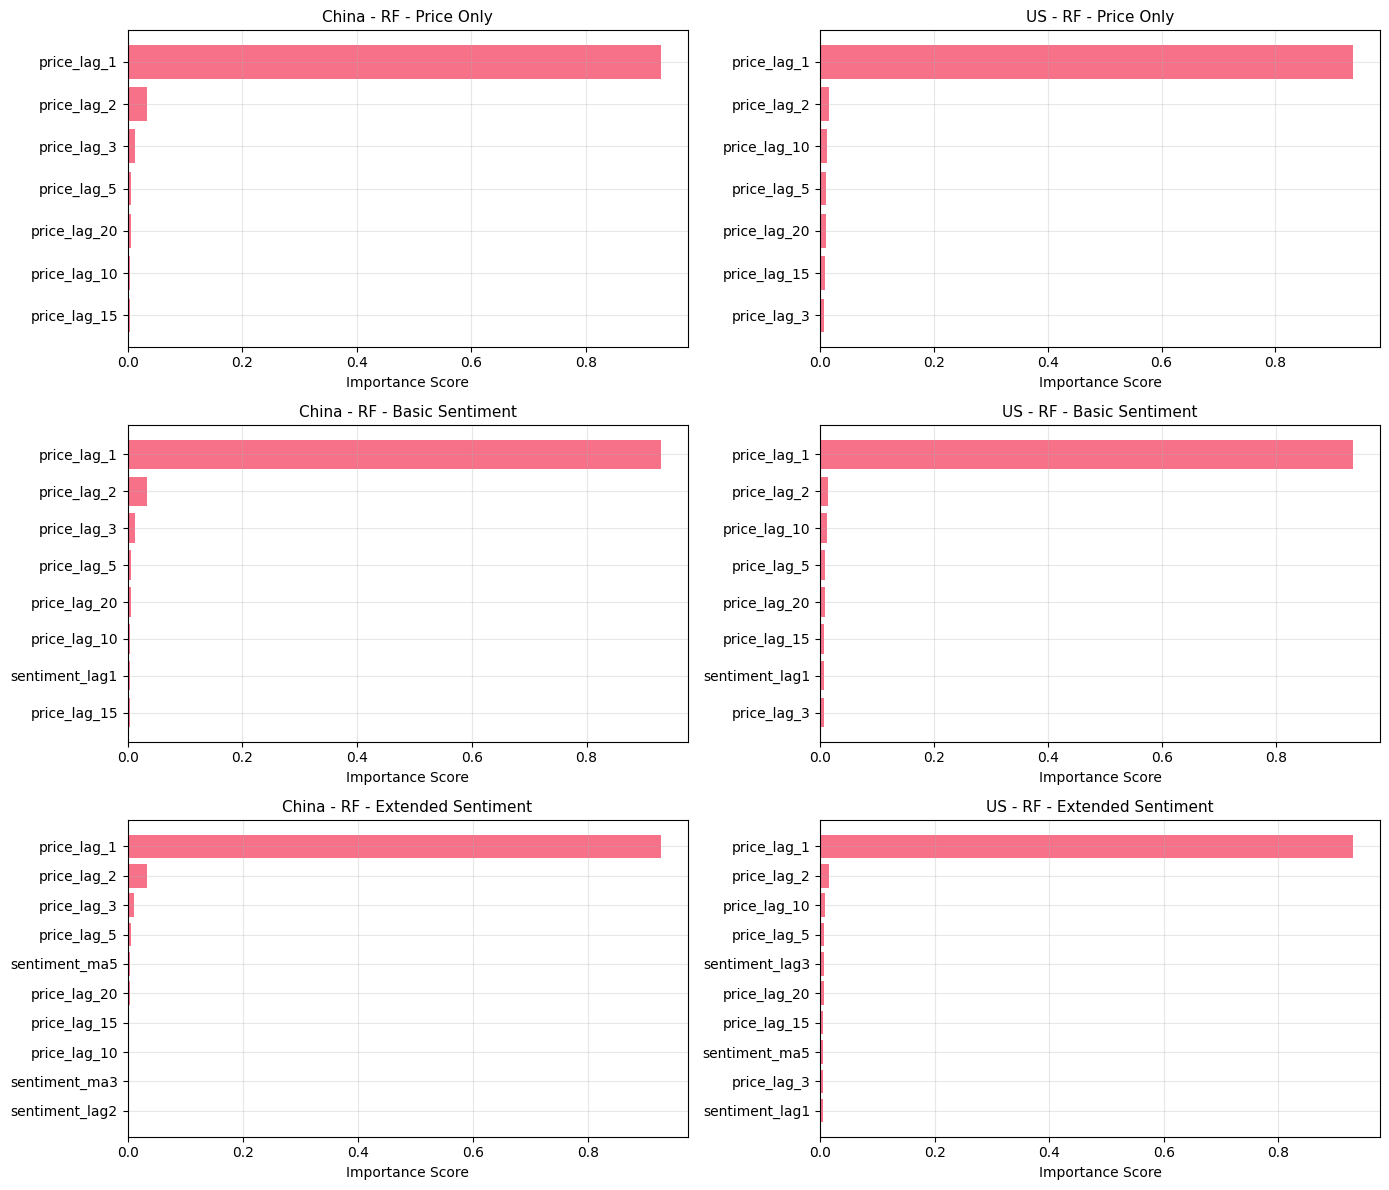

In [25]:
import matplotlib.pyplot as plt
def plot_all_rf_importances_grid_ordered(rf_results, top_n=10):
    # Define desired plot order
    model_order = ['RF - Price Only', 'RF - Basic Sentiment', 'RF - Extended Sentiment']
    countries = ['China', 'US']
    
    # Sort results
    ordered_results = []
    for model in model_order:
        for country in countries:
            for res in rf_results:
                if res['Country'] == country and res['Model'] == model:
                    ordered_results.append(res)

    # Plot in 3x2 grid
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 12))
    axes = axes.flatten()

    for i, result in enumerate(ordered_results):
        importance = result['feature_importance']
        sorted_items = sorted(importance.items(), key=lambda x: x[1], reverse=True)[:top_n]
        labels, values = zip(*sorted_items)
        
        axes[i].barh(labels[::-1], values[::-1])
        axes[i].set_title(f"{result['Country']} - {result['Model']}", fontsize=11)
        axes[i].set_xlabel("Importance Score")
        axes[i].grid(True, alpha=0.3)
    
    # Hide unused axes
    for j in range(len(ordered_results), len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

plot_all_rf_importances_grid_ordered(rf_results)



In [28]:
import matplotlib.pyplot as plt
import numpy as np

def plot_dashboard(results_df, cn_results, us_results):
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('China vs US Market: Sentiment Impact Analysis', fontsize=16, fontweight='bold')

    countries = ['China', 'US']
    models = ['Price Only', 'Price + Basic Sentiment', 'Price + Extended Sentiment']
    x = np.arange(len(models))
    width = 0.35

    # 1. R² Comparison
    ax1 = axes[0, 0]
    r2_data = [[results_df[(results_df['Country'] == c) & (results_df['Model'] == m)]['test_r2'].values[0] for m in models] for c in countries]
    ax1.bar(x - width/2, r2_data[0], width, label='China', alpha=0.8)
    ax1.bar(x + width/2, r2_data[1], width, label='US', alpha=0.8)
    ax1.set_title("Model Performance (R²)")
    ax1.set_ylabel("R² Score")
    ax1.set_xticks(x)
    ax1.set_xticklabels(models, rotation=15)
    ax1.grid(True, alpha=0.3)
    ax1.legend()

    # 2. MAE Comparison
    ax2 = axes[0, 1]
    mae_data = [[results_df[(results_df['Country'] == c) & (results_df['Model'] == m)]['test_mae'].values[0] for m in models] for c in countries]
    ax2.bar(x - width/2, mae_data[0], width, label='China', alpha=0.8)
    ax2.bar(x + width/2, mae_data[1], width, label='US', alpha=0.8)
    ax2.set_title("Prediction Error (MAE)")
    ax2.set_ylabel("Mean Absolute Error")
    ax2.set_xticks(x)
    ax2.set_xticklabels(models, rotation=15)
    ax2.grid(True, alpha=0.3)
    ax2.legend()

    # 3. Direction Accuracy
    ax3 = axes[0, 2]
    dir_data = [[results_df[(results_df['Country'] == c) & (results_df['Model'] == m)]['direction_accuracy'].values[0] for m in models] for c in countries]
    ax3.bar(x - width/2, dir_data[0], width, label='China', alpha=0.8)
    ax3.bar(x + width/2, dir_data[1], width, label='US', alpha=0.8)
    ax3.set_title("Direction Prediction Accuracy")
    ax3.set_ylabel("Direction Accuracy (%)")
    ax3.set_xticks(x)
    ax3.set_xticklabels(models, rotation=15)
    ax3.grid(True, alpha=0.3)
    ax3.legend()

    # 4. China Feature Importance
    ax4 = axes[1, 0]
    cn_importance = cn_results['basic_sentiment']['feature_importance']
    cn_top = sorted(cn_importance.items(), key=lambda x: x[1], reverse=True)[:8]
    ax4.barh([f[0] for f in cn_top][::-1], [f[1] for f in cn_top][::-1], color='blue')
    ax4.set_title("China: Feature Importance")
    ax4.set_xlabel("Feature Importance")
    ax4.grid(True, alpha=0.3)

    # 5. US Feature Importance
    ax5 = axes[1, 1]
    us_importance = us_results['basic_sentiment']['feature_importance']
    us_top = sorted(us_importance.items(), key=lambda x: x[1], reverse=True)[:8]
    ax5.barh([f[0] for f in us_top][::-1], [f[1] for f in us_top][::-1], color='red')
    ax5.set_title("US: Feature Importance")
    ax5.set_xlabel("Feature Importance")
    ax5.grid(True, alpha=0.3)

    # 6. Prediction Quality Scatter
    ax6 = axes[1, 2]
    cn_preds = cn_results['basic_sentiment']['predictions'][:50]
    cn_actuals = cn_results['basic_sentiment']['actuals'][:50]
    us_preds = us_results['basic_sentiment']['predictions'][:50]
    us_actuals = us_results['basic_sentiment']['actuals'][:50]
    ax6.scatter(cn_actuals, cn_preds, label='China', alpha=0.6)
    ax6.scatter(us_actuals, us_preds, label='US', alpha=0.6)
    min_val = min(np.min(cn_actuals), np.min(us_actuals))
    max_val = max(np.max(cn_actuals), np.max(us_actuals))
    ax6.plot([min_val, max_val], [min_val, max_val], 'k--', label='Perfect Prediction', alpha=0.5)
    ax6.set_title("Prediction Quality (First 50 Test Points)")
    ax6.set_xlabel("Actual Price")
    ax6.set_ylabel("Predicted Price")
    ax6.legend()
    ax6.grid(True, alpha=0.3)

    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    plt.show()


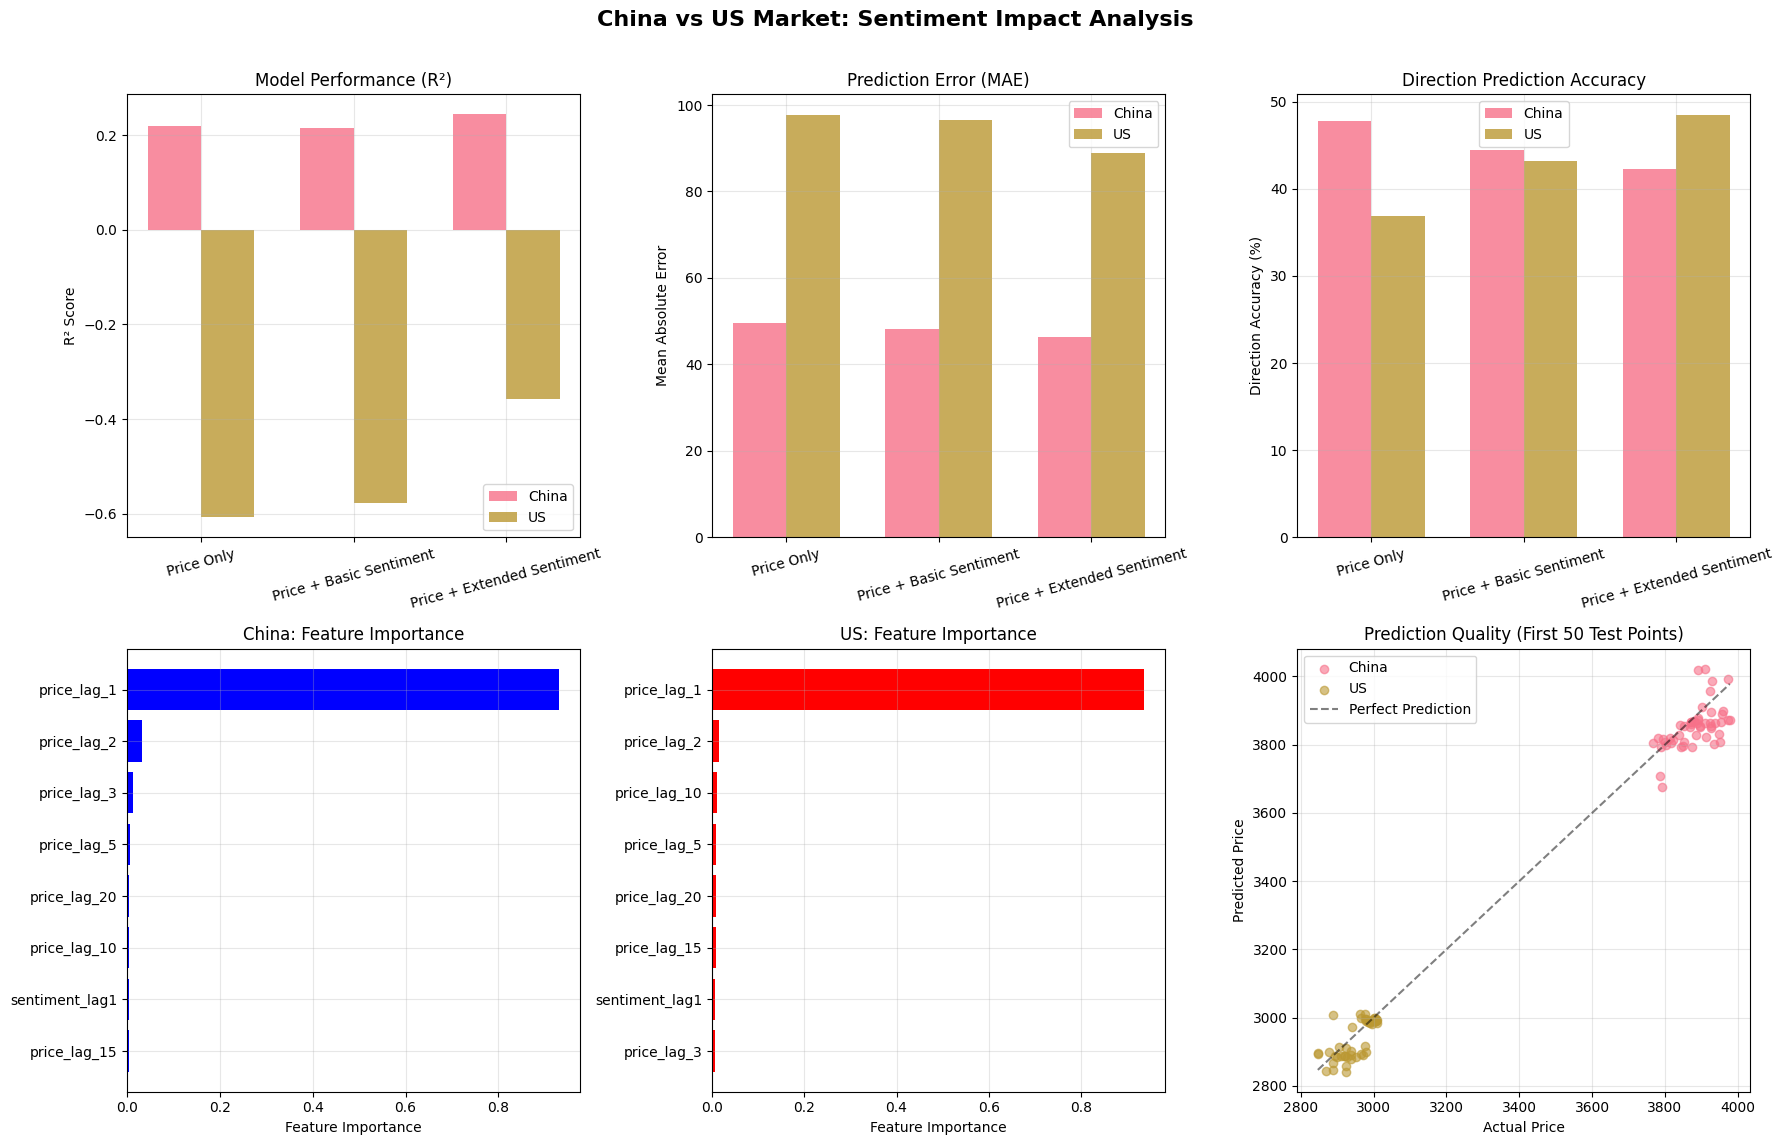

In [29]:
def add_direction_accuracy(results):
    for r in results:
        preds = np.array(r.get('predictions'))
        actuals = np.array(r.get('actuals'))
        if preds is not None and actuals is not None and len(preds) > 1:
            actual_direction = (actuals[1:] > actuals[:-1]).astype(int)
            pred_direction = (preds[1:] > preds[:-1]).astype(int)
            acc = np.mean(actual_direction == pred_direction) * 100
            r['direction_accuracy'] = acc
        else:
            r['direction_accuracy'] = np.nan

add_direction_accuracy(rf_results)

# Create the DataFrame expected by plot_dashboard
results_df = pd.DataFrame([
    {
        'Country': r['Country'],
        'Model': r['Model'].replace("RF - ", "Price + ").replace("Price + Price", "Price"),  # match XGBoost labels
        'test_r2': r['R2'],
        'test_mae': r['MAE'],
        'direction_accuracy': r['direction_accuracy']
    }
    for r in rf_results
])

cn_results = {}
us_results = {}

for result in rf_results:
    key = result['Model'].replace("RF - ", "").strip().lower().replace(" ", "_")  # e.g., 'price_only'
    entry = {
        "feature_importance": result['feature_importance'],
        "predictions": result.get('predictions'),
        "actuals": result.get('actuals'),
        "test_r2": result['R2'],
        "test_mae": result['MAE'],
    }
    if result['Country'] == 'China':
        cn_results[key] = entry
    elif result['Country'] == 'US':
        us_results[key] = entry
plot_dashboard(results_df, cn_results, us_results)


# VAR

In [30]:
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests

cn_var_df = cn_df[['date', 'Price', 'sentiment_score']].copy()
us_var_df = us_df[['date', 'Price', 'sentiment_score']].copy()

cn_var_df['date'] = pd.to_datetime(cn_var_df['date'])
us_var_df['date'] = pd.to_datetime(us_var_df['date'])

cn_var_df.set_index('date', inplace=True)
us_var_df.set_index('date', inplace=True)

cn_var_df.dropna(inplace=True)
us_var_df.dropna(inplace=True)

cn_model = VAR(cn_var_df)
cn_fitted = cn_model.fit(maxlags=15, ic='aic')

us_model = VAR(us_var_df)
us_fitted = us_model.fit(maxlags=15, ic='aic')

cn_gc_test = grangercausalitytests(cn_var_df[['Price', 'sentiment_score']], maxlag=5, verbose=False)
us_gc_test = grangercausalitytests(us_var_df[['Price', 'sentiment_score']], maxlag=5, verbose=False)

def extract_gc_pvals(gc_result):
    return {lag: round(gc_result[lag][0]['ssr_ftest'][1], 4) for lag in gc_result}

{
    "China Granger p-values": extract_gc_pvals(cn_gc_test),
    "US Granger p-values": extract_gc_pvals(us_gc_test)
}


/Users/janedoe/Desktop/Research Paper/finance-nlp/finance-nlp/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/janedoe/Desktop/Research Paper/finance-nlp/finance-nlp/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


{'China Granger p-values': {np.int64(1): np.float64(0.3261),
  np.int64(2): np.float64(0.0665),
  np.int64(3): np.float64(0.1369),
  np.int64(4): np.float64(0.2041),
  np.int64(5): np.float64(0.2882)},
 'US Granger p-values': {np.int64(1): np.float64(0.3173),
  np.int64(2): np.float64(0.4739),
  np.int64(3): np.float64(0.68),
  np.int64(4): np.float64(0.8248),
  np.int64(5): np.float64(0.7151)}}

# Statistical Test

In [33]:

def create_features(df, use_sentiment=True):
    df = df.copy()
    for lag in lags:
        df[f'price_lag_{lag}'] = df['Price'].shift(lag)
    if use_sentiment:
        features = [f'price_lag_{lag}' for lag in lags] + ['sentiment_lag1']
    else:
        features = [f'price_lag_{lag}' for lag in lags]
    
    df['target_price'] = df['Price'].shift(-1)
    df = df.dropna(subset=features + ['target_price'])

    X = df[features]
    y = df['target_price']
    return X, y


In [36]:
from scipy.stats import ttest_rel, wilcoxon
from xgboost import XGBRegressor

def get_abs_errors(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    return np.abs(y_test.values - preds)

def prepare_split(df, use_sentiment):
    X, y = create_features(df, use_sentiment=use_sentiment)
    split_idx = int(len(X) * 0.8)
    return X.iloc[:split_idx], X.iloc[split_idx:], y.iloc[:split_idx], y.iloc[split_idx:]

# China
X_cn_train, X_cn_test, y_cn_train, y_cn_test = prepare_split(cn_df, use_sentiment=False)
model_no = XGBRegressor(n_estimators=50, max_depth=3, random_state=42)
err_cn_no = get_abs_errors(model_no, X_cn_train, X_cn_test, y_cn_train, y_cn_test)

X_cn_train_s, X_cn_test_s, y_cn_train_s, y_cn_test_s = prepare_split(cn_df, use_sentiment=True)
model_sent = XGBRegressor(n_estimators=50, max_depth=3, random_state=42)
err_cn_sent = get_abs_errors(model_sent, X_cn_train_s, X_cn_test_s, y_cn_train_s, y_cn_test_s)

# US
X_us_train, X_us_test, y_us_train, y_us_test = prepare_split(us_df, use_sentiment=False)
err_us_no = get_abs_errors(model_no, X_us_train, X_us_test, y_us_train, y_us_test)

X_us_train_s, X_us_test_s, y_us_train_s, y_us_test_s = prepare_split(us_df, use_sentiment=True)
err_us_sent = get_abs_errors(model_sent, X_us_train_s, X_us_test_s, y_us_train_s, y_us_test_s)

# Statistical tests
print("China Paired t-test:", ttest_rel(err_cn_no, err_cn_sent))
print("China Wilcoxon:", wilcoxon(err_cn_no, err_cn_sent))

print("US Paired t-test:", ttest_rel(err_us_no, err_us_sent))
print("US Wilcoxon:", wilcoxon(err_us_no, err_us_sent))


China Paired t-test: TtestResult(statistic=np.float64(0.6372317303812391), pvalue=np.float64(0.5255916276922568), df=np.int64(90))
China Wilcoxon: WilcoxonResult(statistic=np.float64(1932.0), pvalue=np.float64(0.5239796944009214))
US Paired t-test: TtestResult(statistic=np.float64(0.25646884551070875), pvalue=np.float64(0.7981434164081571), df=np.int64(95))
US Wilcoxon: WilcoxonResult(statistic=np.float64(2232.0), pvalue=np.float64(0.7256979145069489))


In [37]:
from sklearn.ensemble import RandomForestRegressor

def get_abs_errors_rf(X_train, X_test, y_train, y_test):
    model = RandomForestRegressor(n_estimators=100, max_depth=6, random_state=42)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    return np.abs(y_test.values - preds)

def prepare_split(df, use_sentiment):
    X, y = create_features(df, use_sentiment=use_sentiment)
    split_idx = int(len(X) * 0.8)
    return X.iloc[:split_idx], X.iloc[split_idx:], y.iloc[:split_idx], y.iloc[split_idx:]

# China RF
X_cn_train_no, X_cn_test_no, y_cn_train_no, y_cn_test_no = prepare_split(cn_df, use_sentiment=False)
X_cn_train_sent, X_cn_test_sent, y_cn_train_sent, y_cn_test_sent = prepare_split(cn_df, use_sentiment=True)

err_cn_rf_no = get_abs_errors_rf(X_cn_train_no, X_cn_test_no, y_cn_train_no, y_cn_test_no)
err_cn_rf_sent = get_abs_errors_rf(X_cn_train_sent, X_cn_test_sent, y_cn_train_sent, y_cn_test_sent)

# US RF
X_us_train_no, X_us_test_no, y_us_train_no, y_us_test_no = prepare_split(us_df, use_sentiment=False)
X_us_train_sent, X_us_test_sent, y_us_train_sent, y_us_test_sent = prepare_split(us_df, use_sentiment=True)

err_us_rf_no = get_abs_errors_rf(X_us_train_no, X_us_test_no, y_us_train_no, y_us_test_no)
err_us_rf_sent = get_abs_errors_rf(X_us_train_sent, X_us_test_sent, y_us_train_sent, y_us_test_sent)

# Statistical tests
print("RF China Paired t-test:", ttest_rel(err_cn_rf_no, err_cn_rf_sent))
print("RF China Wilcoxon:", wilcoxon(err_cn_rf_no, err_cn_rf_sent))

print("RF US Paired t-test:", ttest_rel(err_us_rf_no, err_us_rf_sent))
print("RF US Wilcoxon:", wilcoxon(err_us_rf_no, err_us_rf_sent))


RF China Paired t-test: TtestResult(statistic=np.float64(1.1809078184562125), pvalue=np.float64(0.24075073495589672), df=np.int64(90))
RF China Wilcoxon: WilcoxonResult(statistic=np.float64(1401.0), pvalue=np.float64(0.006165057827430318))
RF US Paired t-test: TtestResult(statistic=np.float64(4.544101531212465), pvalue=np.float64(1.6221434111192465e-05), df=np.int64(95))
RF US Wilcoxon: WilcoxonResult(statistic=np.float64(1180.0), pvalue=np.float64(2.7172076636468642e-05))
